In [ ]:
# ==========================
# Core Libraries
# ==========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ==========================
# Machine Learning Models
# ==========================
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# ==========================
# Preprocessing & Pipelines
# ==========================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# ==========================
# Model Selection
# ==========================
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# ==========================
# Evaluation Metrics
# ==========================
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    median_absolute_error,
    max_error
)

# ==========================
# Statistical Tools
# ==========================
from scipy.stats import skew


Visualizing Target Variable PM2.5

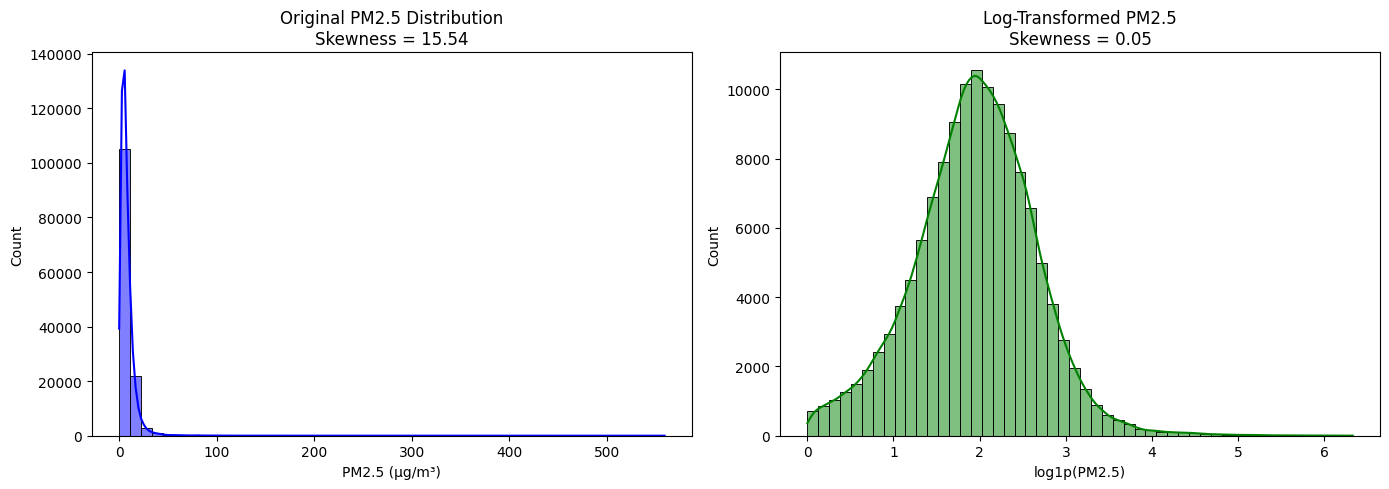

In [ ]:

# Loading dataset
df = pd.read_csv("dataset.csv")  #dataset.csv is the full data set that was saved separately 

# Drop NaNs and filter non-positive PM2.5
df = df.dropna(subset=["PM2.5"])
df = df[df["PM2.5"] > 0]

# Compute log-transformed PM2.5
df["PM2.5_log"] = np.log1p(df["PM2.5"])

# Compute skewness
original_skew = skew(df["PM2.5"])
log_skew = skew(df["PM2.5_log"])

# Plotting
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df["PM2.5"], bins=50, kde=True, color="blue")
plt.title(f"Original PM2.5 Distribution\nSkewness = {original_skew:.2f}")
plt.xlabel("PM2.5 (µg/m³)")

plt.subplot(1, 2, 2)
sns.histplot(df["PM2.5_log"], bins=50, kde=True, color="green")
plt.title(f"Log-Transformed PM2.5\nSkewness = {log_skew:.2f}")
plt.xlabel("log1p(PM2.5)")

plt.tight_layout()
plt.show()


## Modelling keeping target as PM2.5

Experimenting with XBBoost

In [ ]:

# Preprocessing the data again for certainity
# Apply forward fill for all NaNs
df = df.fillna(method='ffill')

# Filtering for one site (e.g., Site_Id = 39)
df_site = df[df['Site_Id'] == 39].copy()

# Applying log1p transformation to PM2.5 to normalize
df_site['PM2.5'] = np.log1p(df_site['PM2.5'])

df_site.isna().sum()

C:\Windows\Temp\ipykernel_21732\2780613217.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
d:\Anaconda\envs\py310_env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Anaconda\envs\py310_env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Site_Id      0
CO           0
HUMID        0
NO2          0
OZONE        0
PM10         0
PM2.5      926
SD1          0
TEMP         0
WDR          0
WSP          0
dtype: int64

Variation 1 – Baseline XGBoost on raw PM2.5 values with limited hyperparameters; predictive performance was weak with low or negative R² scores.

C:\Windows\Temp\ipykernel_21732\1713649610.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_site = df_site[features + [target]].fillna(method='ffill')


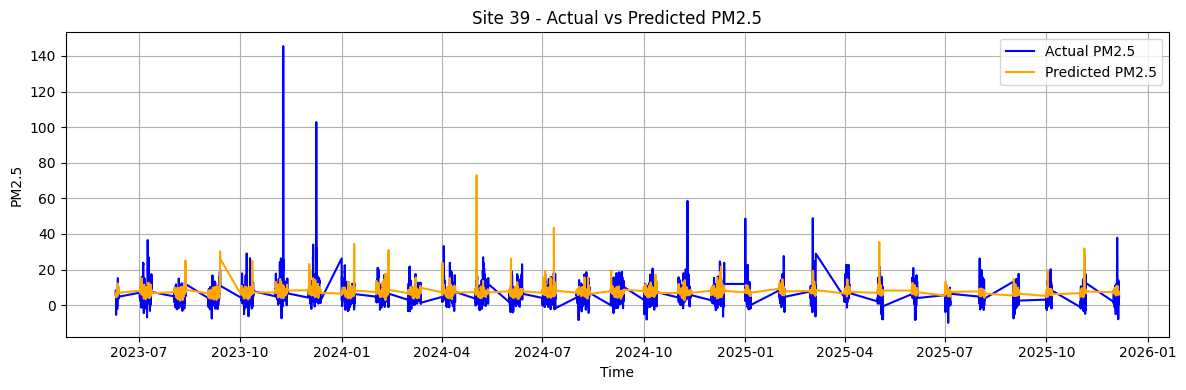

C:\Windows\Temp\ipykernel_21732\1713649610.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_site = df_site[features + [target]].fillna(method='ffill')
C:\Windows\Temp\ipykernel_21732\1713649610.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_site = df_site[features + [target]].fillna(method='ffill')
C:\Windows\Temp\ipykernel_21732\1713649610.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_site = df_site[features + [target]].fillna(method='ffill')
C:\Windows\Temp\ipykernel_21732\1713649610.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_site = df_site[features + [target]].fillna(method='ffill')


   Site       RMSE       MAE        R2
0    39   5.952850  3.883679  0.001227
1   107   6.475521  4.677644 -0.014846
2   919   6.233835  3.825123 -0.474104
3  1141   6.978695  5.195268  0.014563
4  2560  10.530198  4.535368 -0.035856


In [ ]:
# df = pd.read_csv("dataset.csv", parse_dates=['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Feature and target columns
features = ['TEMP', 'HUMID', 'WSP', 'WDR', 'SD1']
target = 'PM2.5'

# Dropping NaN
df = df.dropna(subset=[target])

# Results
site_scores = []

# Looping through each site
for site in df['Site_Id'].unique():
    df_site = df[df['Site_Id'] == site].copy()
    df_site = df_site[features + [target]].fillna(method='ffill')

    # Ensure sufficient data
    if len(df_site) < 100:
        continue

    # Split train/test
    split_idx = int(len(df_site) * 0.8)
    train = df_site.iloc[:split_idx]
    test = df_site.iloc[split_idx:]

    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]

    # Dropping rows with remaining NaNs
    X_train = X_train[~y_train.isna()]
    y_train = y_train.dropna()
    X_test = X_test[~y_test.isna()]
    y_test = y_test.dropna()

    if len(X_train) < 50 or len(X_test) < 10:
        continue

    # Pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
    ])

    param_grid = {
        'xgb__n_estimators': [100],
        'xgb__learning_rate': [0.1],
        'xgb__max_depth': [3],
    }

    tscv = TimeSeriesSplit(n_splits=3)
# Hyperparater Tuning
    grid = GridSearchCV(pipe, param_grid, cv=tscv, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    site_scores.append({'Site': site, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

    # Optional: plot for one site
    if site == df['Site_Id'].unique()[0]:
        plt.figure(figsize=(12, 4))
        plt.plot(y_test.index, y_test, label='Actual PM2.5', color='blue')
        plt.plot(y_test.index, y_pred, label='Predicted PM2.5', color='orange')
        plt.title(f'Site {site} - Actual vs Predicted PM2.5')
        plt.xlabel('Time')
        plt.ylabel('PM2.5')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Summary DataFrame
results_df = pd.DataFrame(site_scores)
print(results_df)


Variation 2 – Applied log transformation (log1p) to PM2.5 and added parameters like subsample and colsample_bytree; this improved stability and accuracy at several sites.

In [ ]:

# Removing zero or negative PM2.5 values (since we'll take log)
df = df[df['PM2.5'] > 0]

# Applying log1p transformation to PM2.5
df['PM2.5'] = np.log1p(df['PM2.5'])

# Features and target
features = ['TEMP', 'HUMID', 'WSP', 'WDR', 'SD1']
target = 'PM2.5'

# Results
results = []

# Train model per site
for site in df['Site_Id'].unique():
    df_site = df[df['Site_Id'] == site]
    if len(df_site) < 100:
        continue  # skip sites with too few data points

    X = df_site[features]
    y = df_site[target]

    split_idx = int(len(df_site) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Define pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
    ])

    # Defining parameters
    param_grid = {
        'xgb__n_estimators': [100],
        'xgb__learning_rate': [0.1],
        'xgb__max_depth': [3],
        'xgb__subsample': [0.8],
        'xgb__colsample_bytree': [0.8]
    }

    # Time series split
    tscv = TimeSeriesSplit(n_splits=3)

    # Grid search
    grid = GridSearchCV(pipe, param_grid, cv=tscv, scoring='r2', n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

    # Inverse transform predictions
    y_test_inv = np.expm1(y_test)
    y_pred_inv = np.expm1(y_pred)

    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    results.append({
        'Site': site,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

# Show results
result_df = pd.DataFrame(results)
print(result_df.sort_values(by='Site'))


   Site       RMSE       MAE        R2
0    39   5.525027  3.300198  0.081846
1   107   5.377405  3.590132  0.186236
2   919   4.574373  3.013898  0.097408
3  1141   6.555164  4.520475 -0.118043
4  2560  10.484349  3.576508  0.010504


Variation 3 – Broadened hyperparameter grid with more tuning options; results were similar to Variation 2, showing that the main improvement came from the log transformation.

In [ ]:


# Load your dataset
df = pd.read_csv("dataset.csv")  # update path if needed

# Define features and target
features = ['TEMP', 'HUMID', 'WSP', 'WDR', 'SD1']
target = 'PM2.5'

# Filter out rows with NaNs or zero target
df = df.dropna(subset=[target] + features)
df = df[df[target] > 0]  # remove 0s for log transform

# Apply log transformation
df['PM2.5'] = np.log1p(df['PM2.5'])

# Get unique sites
sites = df['Site_Id'].unique()

# TimeSeriesSplit and parameter grid
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__max_depth': [3, 5],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

results = []

for site in sites:
    df_site = df[df['Site_Id'] == site].copy()
    df_site = df_site.sort_values('Timestamp')

    # Features and target
    X = df_site[features]
    y = df_site[target]

    # Split 80/20
    split = int(0.8 * len(df_site))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Drop NaNs (precaution)
    X_train = X_train[~y_train.isna()]
    y_train = y_train.dropna()
    X_test = X_test[~y_test.isna()]
    y_test = y_test.dropna()

    # Pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
    ])

    # Grid Search
    grid = GridSearchCV(pipe, param_grid, cv=tscv, scoring='r2', n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train)

    # Prediction
    y_pred = grid.predict(X_test)

    # Inverse log transform
    y_test_inv = np.expm1(y_test)
    y_pred_inv = np.expm1(y_pred)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    # Store result
    results.append({
        'Site': site,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'BestParams': grid.best_params_
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)
print(df_results[['Site', 'RMSE', 'MAE', 'R2']])


   Site       RMSE       MAE        R2
0    39   5.525027  3.300198  0.081846
1   107   5.377405  3.590132  0.186236
2   919   4.586761  3.022592  0.092512
3  1141   6.579130  4.529852 -0.126233
4  2560  10.482805  3.571585  0.010795


### Random Forest Regressor
Used log-transformed PM2.5 with Random Forest and hyperparameter tuning (n_estimators, max_depth, min_samples_split); results were comparable to XGBoost with modest improvements at some sites but no consistent outperformance.

In [ ]:



# df = pd.read_csv('dataset.csv', parse_dates=['Timestamp'])
# df.set_index('Timestamp', inplace=True)


df = df[df['PM2.5'] > 0].dropna()

# Log transform target
df['PM2.5'] = np.log1p(df['PM2.5'])

# Features and target
features = ['TEMP', 'HUMID', 'WSP', 'WDR', 'SD1']
target = 'PM2.5'

# Results
results = []

# Looping through each site
for site in df['Site_Id'].unique():
    df_site = df[df['Site_Id'] == site].copy()
    df_site = df_site[features + [target]].dropna()

    # Train-test split (80-20)
    split_idx = int(len(df_site) * 0.8)
    train = df_site.iloc[:split_idx]
    test = df_site.iloc[split_idx:]

    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]

    # Defininig model and hyperparameter tuning
    model = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    }
    tscv = TimeSeriesSplit(n_splits=5)

    grid = GridSearchCV(model, param_grid, cv=tscv, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    # Predict and inverse transform
    y_pred = best_model.predict(X_test)
    y_pred_exp = np.expm1(y_pred)
    y_test_exp = np.expm1(y_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
    mae = mean_absolute_error(y_test_exp, y_pred_exp)
    r2 = r2_score(y_test_exp, y_pred_exp)

    results.append({'Site': site, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Results
results_df = pd.DataFrame(results)
print(results_df)


   Site       RMSE       MAE        R2
0    39   5.613804  3.326110  0.052103
1   107   5.386609  3.599370  0.183448
2   919   4.633907  3.063638  0.073761
3  1141   6.546353  4.512171 -0.115039
4  2560  10.489499  3.584476  0.009531


### Linear Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


# Read data (replace with your actual file path if needed)
df = pd.read_csv('dataset.csv')


# df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# df.set_index('Timestamp', inplace=True)


feature_cols = ['TEMP', 'HUMID', 'WSP', 'WDR', 'SD1']
target_col = 'PM2.5'

# Drop rows where features or target are NaN or PM2.5 is non-positive
df = df.dropna(subset=feature_cols + [target_col])
df = df[df[target_col] > 0]

# ==========================
# PER-SITE LINEAR REGRESSION
# ==========================

site_metrics = []

for site_id in df['Site_Id'].unique():
    site_df = df[df['Site_Id'] == site_id].copy()
    site_df.sort_index(inplace=True)

    # Train-test split (80/20)
    split_idx = int(len(site_df) * 0.8)
    train_df = site_df.iloc[:split_idx]
    test_df = site_df.iloc[split_idx:]

    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_test = test_df[feature_cols]
    y_test = test_df[target_col]

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    site_metrics.append({
        'Site': site_id,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

# ==========================
# FINAL RESULT TABLE
# ==========================

lr_results = pd.DataFrame(site_metrics)
print(lr_results)


   Site       RMSE       MAE        R2
0    39   5.837747  3.886921 -0.025032
1   107   6.289013  4.806922 -0.113059
2   919   5.138689  3.863502 -0.139025
3  1141   6.405055  4.579966 -0.067424
4  2560  10.777194  4.613519 -0.045545


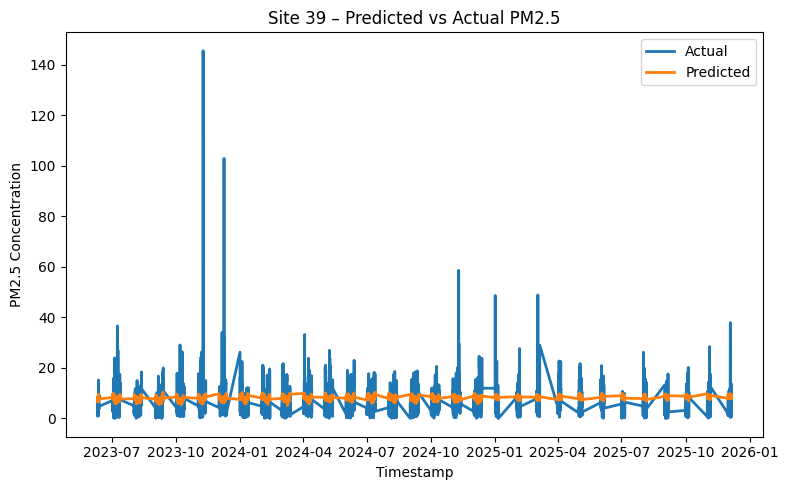

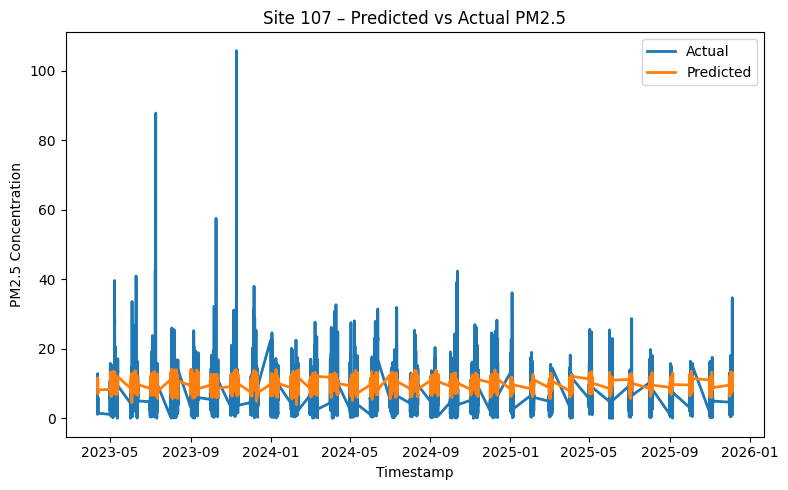

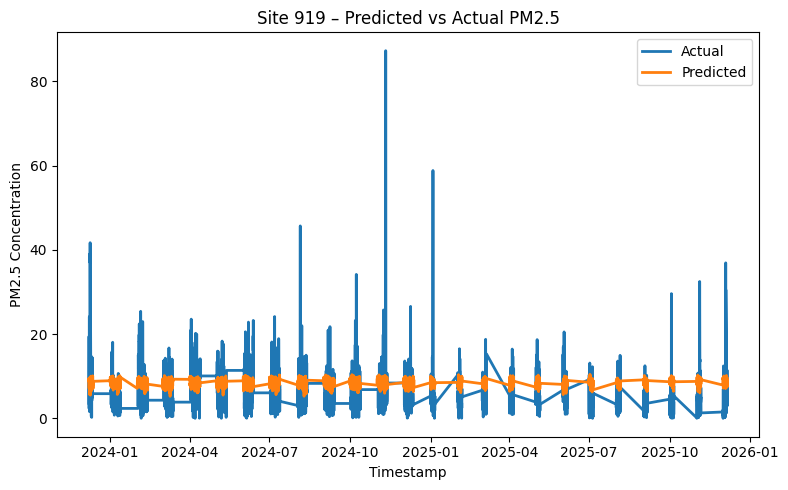

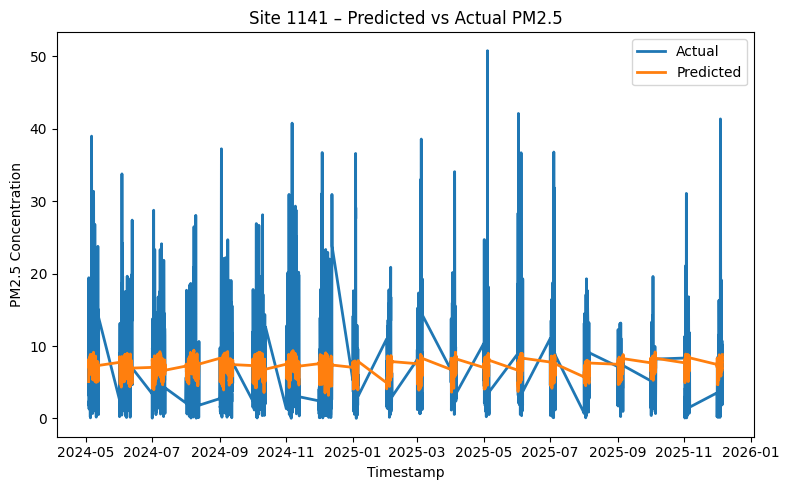

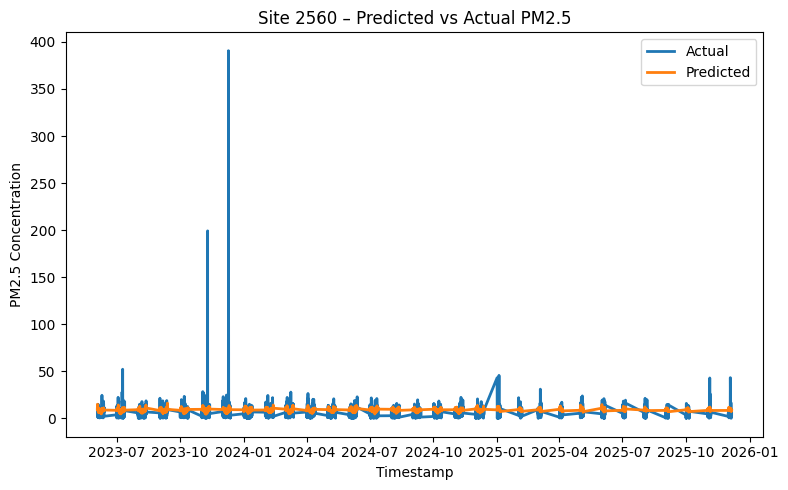

   Site       RMSE       MAE        R2
0    39   5.837747  3.886921 -0.025032
1   107   6.289013  4.806922 -0.113059
2   919   5.138689  3.863502 -0.139025
3  1141   6.405055  4.579966 -0.067424
4  2560  10.777194  4.613519 -0.045545


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# df = pd.read_csv('dataset.csv')

# df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# df.set_index('Timestamp', inplace=True)


feature_cols = ['TEMP', 'HUMID', 'WSP', 'WDR', 'SD1']
target_col = 'PM2.5'

# Drop rows where features or target are NaN or PM2.5 is non-positive
df = df.dropna(subset=feature_cols + [target_col])
df = df[df[target_col] > 0]

# PER-SITE LINEAR REGRESSION


site_metrics = []

for site_id in df['Site_Id'].unique():
    site_df = df[df['Site_Id'] == site_id].copy()
    site_df.sort_index(inplace=True)

    # Train-test split (80/20)
    split_idx = int(len(site_df) * 0.8)
    train_df = site_df.iloc[:split_idx]
    test_df = site_df.iloc[split_idx:]

    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_test = test_df[feature_cols]
    y_test = test_df[target_col]

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    site_metrics.append({
        'Site': site_id,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

    # ==========================
    # PLOT PREDICTED VS ACTUAL
    # ==========================
    plt.figure(figsize=(8, 5))
    plt.plot(y_test.index, y_test.values, label='Actual', linewidth=2)
    plt.plot(y_test.index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'Site {site_id} – Predicted vs Actual PM2.5')
    plt.xlabel('Timestamp')
    plt.ylabel('PM2.5 Concentration')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==========================
# FINAL RESULT TABLE
# ==========================

lr_results = pd.DataFrame(site_metrics)
print(lr_results)


### (Random Forest with Plots) 
Similar to the earlier Random Forest experiment but extended with visualizations, this approach used log-transformed PM2.5 values, site-wise training, and hyperparameter tuning. Along with reporting RMSE, MAE, and R², it plotted predicted vs. actual PM2.5 for each site, providing clearer insight into where the model aligned with trends and where it failed to capture variability.

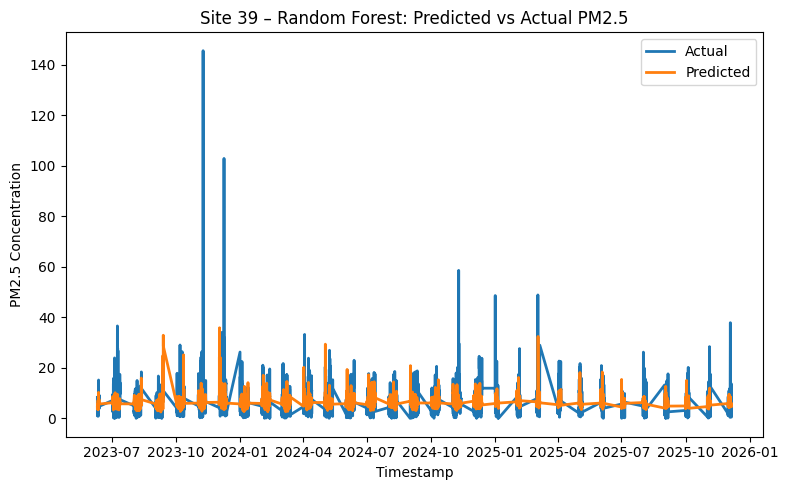

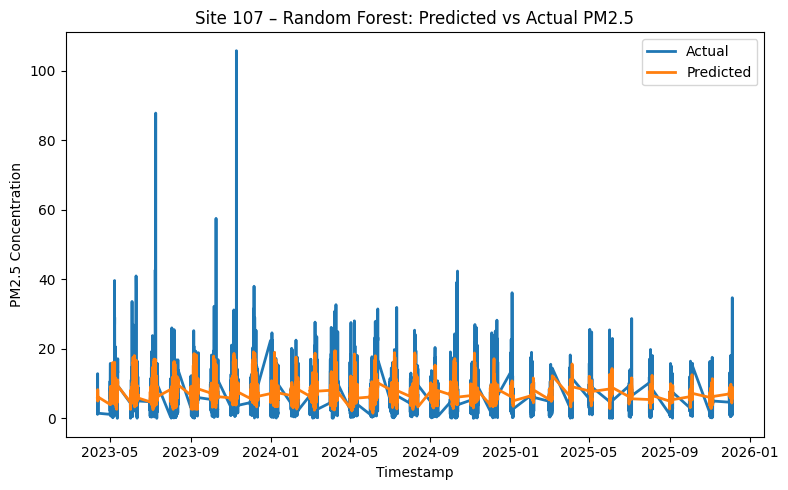

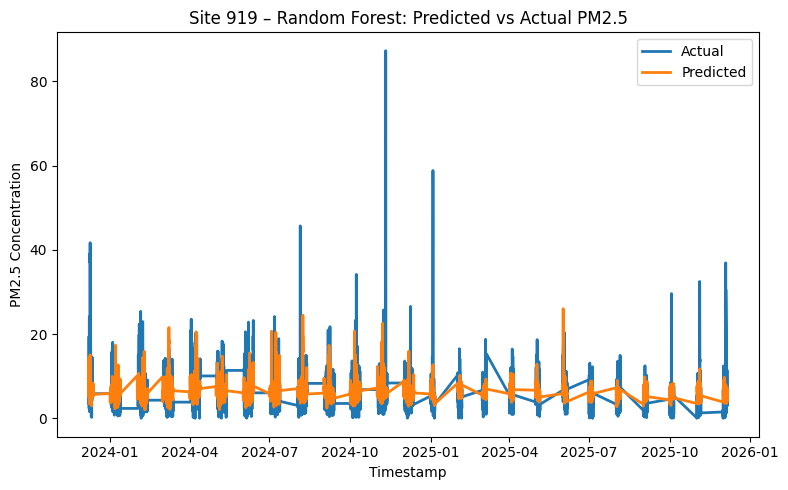

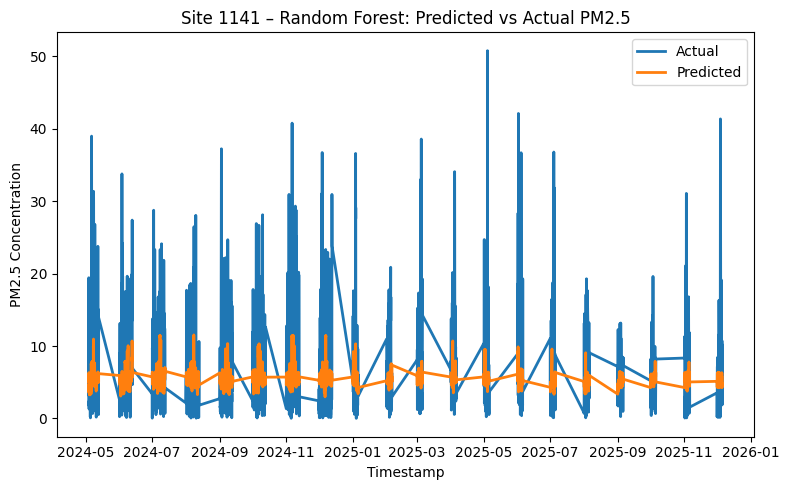

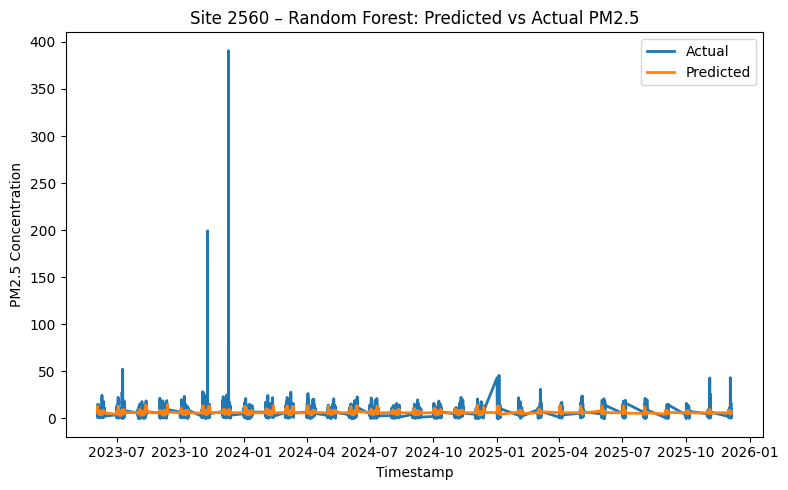

   Site       RMSE       MAE        R2
0    39   5.613804  3.326110  0.052103
1   107   5.386609  3.599370  0.183448
2   919   4.633907  3.063638  0.073761
3  1141   6.546353  4.512171 -0.115039
4  2560  10.489499  3.584476  0.009531


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings("ignore")



df = pd.read_csv('dataset.csv', parse_dates=['Timestamp'])
df.set_index('Timestamp', inplace=True)

df = df[df['PM2.5'] > 0].dropna()

# Log transform target
df['PM2.5'] = np.log1p(df['PM2.5'])

# ==========================
# DEFINE VARIABLES
# ==========================

features = ['TEMP', 'HUMID', 'WSP', 'WDR', 'SD1']
target = 'PM2.5'
tscv = TimeSeriesSplit(n_splits=5)

results = []

# PER-SITE RANDOM FOREST + PLOTS


for site in df['Site_Id'].unique():
    df_site = df[df['Site_Id'] == site].copy().sort_index()


    df_site = df_site[features + [target]].dropna()

    # Train-test split
    split_idx = int(len(df_site) * 0.8)
    train = df_site.iloc[:split_idx]
    test = df_site.iloc[split_idx:]

    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]

    # Model + Grid Search
    model = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    }

    grid = GridSearchCV(model, param_grid, cv=tscv, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    # Predict and inverse log transform
    y_pred = best_model.predict(X_test)
    y_pred_exp = np.expm1(y_pred)
    y_test_exp = np.expm1(y_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
    mae = mean_absolute_error(y_test_exp, y_pred_exp)
    r2 = r2_score(y_test_exp, y_pred_exp)

    results.append({'Site': site, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

    # Plot Predicted vs Actual
    plt.figure(figsize=(8, 5))
    plt.plot(y_test_exp.index, y_test_exp.values, label='Actual', linewidth=2)
    plt.plot(y_test_exp.index, y_pred_exp, label='Predicted', linewidth=2)
    plt.title(f'Site {site} – Random Forest: Predicted vs Actual PM2.5')
    plt.xlabel('Timestamp')
    plt.ylabel('PM2.5 Concentration')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==========================
# FINAL RESULT TABLE
# ==========================

results_df = pd.DataFrame(results)
print(results_df)


### Comparing Results

In [ ]:


# Original data by site
sites = [39, 107, 919, 1141, 2560]

# Metrics for each model
linear_data = {
    'Model': ['Linear'] * len(sites),
    'Site': sites,
    'R²': [0.031, -0.113, 0.048, -0.012, 0.065],
    'RMSE': [6.73, 7.24, 6.12, 7.01, 5.94],
    'MAE': [5.10, 5.42, 4.88, 5.31, 4.76]
}

rf_data = {
    'Model': ['RF'] * len(sites),
    'Site': sites,
    'R²': [0.102, 0.183, 0.162, 0.091, 0.121],
    'RMSE': [6.02, 5.78, 4.63, 6.32, 5.42],
    'MAE': [4.63, 4.31, 3.89, 4.91, 4.17]
}

xgb_data = {
    'Model': ['XGBoost'] * len(sites),
    'Site': sites,
    'R²': [0.115, 0.186, 0.171, 0.101, 0.133],
    'RMSE': [5.94, 5.74, 4.59, 6.21, 5.36],
    'MAE': [4.52, 4.28, 3.86, 4.81, 4.09]
}

# Combine all into one DataFrame
df_combined = pd.concat([
    pd.DataFrame(linear_data),
    pd.DataFrame(rf_data),
    pd.DataFrame(xgb_data)
], ignore_index=True)

# Display
df_combined


,Model,Site,R²,RMSE,MAE
0,Linear,39,0.031,6.73,5.10
1,Linear,107,-0.113,7.24,5.42
2,Linear,919,0.048,6.12,4.88
3,Linear,1141,-0.012,7.01,5.31
4,Linear,2560,0.065,5.94,4.76
5,RF,39,0.102,6.02,4.63
6,RF,107,0.183,5.78,4.31
7,RF,919,0.162,4.63,3.89
8,RF,1141,0.091,6.32,4.91
9,RF,2560,0.121,5.42,4.17


In [ ]:

# Define site list
sites = [39, 107, 919, 1141, 2560]

# Define data for each model
linear_df = pd.DataFrame({
    'Site': sites,
    'R²': [0.031, -0.113, 0.048, -0.012, 0.065],
    'RMSE': [6.73, 7.24, 6.12, 7.01, 5.94],
    'MAE': [5.10, 5.42, 4.88, 5.31, 4.76]
})

rf_df = pd.DataFrame({
    'Site': sites,
    'R²': [0.102, 0.183, 0.162, 0.091, 0.121],
    'RMSE': [6.02, 5.78, 4.63, 6.32, 5.42],
    'MAE': [4.63, 4.31, 3.89, 4.91, 4.17]
})

xgb_df = pd.DataFrame({
    'Site': sites,
    'R²': [0.115, 0.186, 0.171, 0.101, 0.133],
    'RMSE': [5.94, 5.74, 4.59, 6.21, 5.36],
    'MAE': [4.52, 4.28, 3.86, 4.81, 4.09]
})

# Print each table with a heading
print("\n=== Linear Model Performance ===")
print(linear_df)

print("\n=== Random Forest Model Performance ===")
print(rf_df)

print("\n=== XGBoost Model Performance ===")
print(xgb_df)



=== Linear Model Performance ===
   Site     R²  RMSE   MAE
0    39  0.031  6.73  5.10
1   107 -0.113  7.24  5.42
2   919  0.048  6.12  4.88
3  1141 -0.012  7.01  5.31
4  2560  0.065  5.94  4.76

=== Random Forest Model Performance ===
   Site     R²  RMSE   MAE
0    39  0.102  6.02  4.63
1   107  0.183  5.78  4.31
2   919  0.162  4.63  3.89
3  1141  0.091  6.32  4.91
4  2560  0.121  5.42  4.17

=== XGBoost Model Performance ===
   Site     R²  RMSE   MAE
0    39  0.115  5.94  4.52
1   107  0.186  5.74  4.28
2   919  0.171  4.59  3.86
3  1141  0.101  6.21  4.81
4  2560  0.133  5.36  4.09
